<a href="https://colab.research.google.com/github/snvssk/data240/blob/development/RF_FeatureSelection_AdaBoost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scikitplot as skplt

from datetime import datetime
from random import randint
from math import sqrt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, r2_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
import time
from xgboost import XGBClassifier
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,GridSearchCV


In [4]:
# Original Dataset
data = pd.read_csv("./weather_location_combine.csv")

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788400 entries, 0 to 788399
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          788400 non-null  int64  
 1   Year                788400 non-null  int64  
 2   Month               788400 non-null  int64  
 3   Day                 788400 non-null  int64  
 4   Hour                788400 non-null  int64  
 5   Minute              788400 non-null  int64  
 6   Temperature         788400 non-null  float64
 7   Clearsky DHI        788400 non-null  int64  
 8   Clearsky DNI        788400 non-null  int64  
 9   Clearsky GHI        788400 non-null  int64  
 10  Cloud Type          788400 non-null  int64  
 11  Dew Point           788400 non-null  float64
 12  DHI                 788400 non-null  int64  
 13  DNI                 788400 non-null  int64  
 14  GHI                 788400 non-null  int64  
 15  Relative Humidity   788400 non-nul

In [6]:
data['Unnamed: 0']

0             0
1             1
2             2
3             3
4             4
          ...  
788395    17515
788396    17516
788397    17517
788398    17518
788399    17519
Name: Unnamed: 0, Length: 788400, dtype: int64

# Data Pre-Processing

In [7]:
data['outcome'] = np.where(data['GHI'] > 350, 'high',(np.where(data['GHI'] < 200, 'low', 'medium')))

In [8]:
data.head()

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,...,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Location ID,Latitude,Longitude,Elevation,outcome
0,0,2020,1,1,0,0,-2.9,0,0,0,...,0.11,987,0.4,277.0,5.4,903523,41.89,-87.62,179,low
1,1,2020,1,1,0,30,-3.0,0,0,0,...,0.11,987,0.4,275.0,5.2,903523,41.89,-87.62,179,low
2,2,2020,1,1,1,0,-3.1,0,0,0,...,0.11,987,0.4,273.0,5.0,903523,41.89,-87.62,179,low
3,3,2020,1,1,1,30,-3.1,0,0,0,...,0.11,987,0.4,270.0,4.9,903523,41.89,-87.62,179,low
4,4,2020,1,1,2,0,-3.1,0,0,0,...,0.11,987,0.4,267.0,4.8,903523,41.89,-87.62,179,low


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788400 entries, 0 to 788399
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          788400 non-null  int64  
 1   Year                788400 non-null  int64  
 2   Month               788400 non-null  int64  
 3   Day                 788400 non-null  int64  
 4   Hour                788400 non-null  int64  
 5   Minute              788400 non-null  int64  
 6   Temperature         788400 non-null  float64
 7   Clearsky DHI        788400 non-null  int64  
 8   Clearsky DNI        788400 non-null  int64  
 9   Clearsky GHI        788400 non-null  int64  
 10  Cloud Type          788400 non-null  int64  
 11  Dew Point           788400 non-null  float64
 12  DHI                 788400 non-null  int64  
 13  DNI                 788400 non-null  int64  
 14  GHI                 788400 non-null  int64  
 15  Relative Humidity   788400 non-nul

# Data Preperation

In [10]:
# To check number rows in each category
row_count = pd.DataFrame()
row_count['Before'] = data['outcome'].value_counts()
row_count

,Before
low,550439
high,170643
medium,67318


In [11]:
data.head()

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,...,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Location ID,Latitude,Longitude,Elevation,outcome
0,0,2020,1,1,0,0,-2.9,0,0,0,...,0.11,987,0.4,277.0,5.4,903523,41.89,-87.62,179,low
1,1,2020,1,1,0,30,-3.0,0,0,0,...,0.11,987,0.4,275.0,5.2,903523,41.89,-87.62,179,low
2,2,2020,1,1,1,0,-3.1,0,0,0,...,0.11,987,0.4,273.0,5.0,903523,41.89,-87.62,179,low
3,3,2020,1,1,1,30,-3.1,0,0,0,...,0.11,987,0.4,270.0,4.9,903523,41.89,-87.62,179,low
4,4,2020,1,1,2,0,-3.1,0,0,0,...,0.11,987,0.4,267.0,4.8,903523,41.89,-87.62,179,low


In [12]:
list1 = [16,1,18,21,22,23]
data[['GHI','outcome']].loc[data['Unnamed: 0'].isin(list1)].head(6)

,GHI,outcome
1,0,low
16,60,low
18,208,medium
21,291,medium
22,357,high
23,453,high


In [13]:
data = data.loc[(data['Hour'].isin([7, 10, 13, 16, 19])) & (data['Minute'] == 0)]

In [14]:
data.head()

,Unnamed: 0,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,...,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Location ID,Latitude,Longitude,Elevation,outcome
14,14,2020,1,1,7,0,-3.5,0,0,0,...,0.11,987,0.4,236.0,5.0,903523,41.89,-87.62,179,low
20,20,2020,1,1,10,0,0.0,59,875,358,...,0.11,986,0.3,205.0,6.7,903523,41.89,-87.62,179,medium
26,26,2020,1,1,13,0,4.3,70,878,418,...,0.11,982,0.5,204.0,7.4,903523,41.89,-87.62,179,high
32,32,2020,1,1,16,0,3.6,26,340,50,...,0.11,980,0.7,191.0,7.3,903523,41.89,-87.62,179,low
38,38,2020,1,1,19,0,3.2,0,0,0,...,0.11,980,1.1,192.0,8.9,903523,41.89,-87.62,179,low


In [15]:
# To check number rows in each category
row_count['After'] = data['outcome'].value_counts()

In [16]:
row_count['Before_Percentage'] = row_count['Before']/np.sum(row_count['Before']) * 100
row_count['After_Percentage'] = row_count['After']/np.sum(row_count['After']) * 100
row_count

,Before,After,Before_Percentage,After_Percentage
low,550439,42237,69.817225,51.430137
high,170643,28638,21.644216,34.871233
medium,67318,11250,8.538559,13.698630


Based on above we can see the ration is not only maintained but got better for all the categories

In [17]:
data[['Latitude','Longitude','Location ID']]

,Latitude,Longitude,Location ID
14,41.89,-87.62,903523
20,41.89,-87.62,903523
26,41.89,-87.62,903523
32,41.89,-87.62,903523
38,41.89,-87.62,903523
...,...,...,...
788366,47.61,-122.34,241108
788372,47.61,-122.34,241108
788378,47.61,-122.34,241108
788384,47.61,-122.34,241108


In [18]:
data['Location ID'].value_counts()

903523     9125
1324899    9125
701624     9125
484137     9125
471638     9125
1060699    9125
778153     9125
117549     9125
241108     9125
Name: Location ID, dtype: int64

In [19]:

data['Longitude'].value_counts()

-87.62     9125
-71.50     9125
-96.82     9125
-104.98    9125
-151.54    9125
-80.18     9125
-93.26     9125
-121.90    9125
-122.34    9125
Name: Longitude, dtype: int64

In [20]:
data['Latitude'].value_counts()

41.89    9125
43.21    9125
32.77    9125
39.73    9125
59.65    9125
25.77    9125
44.97    9125
37.33    9125
47.61    9125
Name: Latitude, dtype: int64

In [21]:
data.drop('Unnamed: 0', axis=1, inplace=True)  
data.drop('Latitude', axis=1, inplace=True)  
data.drop('Longitude', axis=1, inplace=True)  

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82125 entries, 14 to 788390
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                82125 non-null  int64  
 1   Month               82125 non-null  int64  
 2   Day                 82125 non-null  int64  
 3   Hour                82125 non-null  int64  
 4   Minute              82125 non-null  int64  
 5   Temperature         82125 non-null  float64
 6   Clearsky DHI        82125 non-null  int64  
 7   Clearsky DNI        82125 non-null  int64  
 8   Clearsky GHI        82125 non-null  int64  
 9   Cloud Type          82125 non-null  int64  
 10  Dew Point           82125 non-null  float64
 11  DHI                 82125 non-null  int64  
 12  DNI                 82125 non-null  int64  
 13  GHI                 82125 non-null  int64  
 14  Relative Humidity   82125 non-null  float64
 15  Solar Zenith Angle  82125 non-null  float64
 16  Su

# Data Transformation

In [23]:
X = data.drop(['GHI','outcome'], axis =1)
X

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,DNI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Location ID,Elevation
14,2020,1,1,7,0,-3.5,0,0,0,4,...,0,92.20,93.80,0.11,987,0.400,236.0,5.0,903523,179
20,2020,1,1,10,0,0.0,59,875,358,2,...,414,79.80,70.01,0.11,986,0.300,205.0,6.7,903523,179
26,2020,1,1,13,0,4.3,70,878,418,0,...,878,67.05,66.63,0.11,982,0.500,204.0,7.4,903523,179
32,2020,1,1,16,0,3.6,26,340,50,0,...,203,80.16,86.01,0.11,980,0.700,191.0,7.3,903523,179
38,2020,1,1,19,0,3.2,0,0,0,4,...,0,85.80,117.07,0.11,980,1.100,192.0,8.9,903523,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788366,2016,12,31,7,0,-1.0,0,0,0,4,...,0,88.51,99.30,0.07,1000,0.722,158.8,1.0,241108,49
788372,2016,12,31,10,0,1.0,54,642,202,4,...,642,100.00,76.67,0.07,1000,0.775,188.7,0.9,241108,49
788378,2016,12,31,13,0,2.0,65,729,297,4,...,729,99.53,71.41,0.07,1000,1.055,186.5,1.2,241108,49
788384,2016,12,31,16,0,0.0,17,379,36,1,...,379,73.67,87.15,0.07,1020,0.440,101.8,0.9,241108,49


In [24]:
y = data['outcome']
y

14           low
20        medium
26          high
32           low
38           low
           ...  
788366       low
788372    medium
788378    medium
788384       low
788390       low
Name: outcome, Length: 82125, dtype: object

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [26]:
print(f' Shape of X_train : {X_train.shape}')
print(f' Shape of y_train : {y_train.shape}')
print(f' Shape of X_test : {X_test.shape}')
print(f' Shape of y_test : {y_test.shape}')

 Shape of X_train : (57487, 22)
 Shape of y_train : (57487,)
 Shape of X_test : (24638, 22)
 Shape of y_test : (24638,)


In [27]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=3, random_state=0)
forest = RandomForestClassifier(criterion='entropy',max_depth=3, n_estimators=500, random_state=0)

In [28]:
forest.fit(X_train, y_train)
importances = forest.feature_importances_

In [29]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis=0)
df = pd.DataFrame({'feature' : X_train.columns, 'importance': importances, 'std': std})
df = df.sort_values('importance')

In [30]:
print(df)

               feature    importance       std
4               Minute  0.000000e+00  0.000000
2                  Day  4.657559e-07  0.000009
0                 Year  2.814398e-05  0.000272
20         Location ID  1.161672e-04  0.000909
19          Wind Speed  1.303213e-04  0.001050
16            Pressure  3.291101e-04  0.001543
18      Wind Direction  3.321875e-04  0.001675
15      Surface Albedo  9.247033e-04  0.004668
17  Precipitable Water  9.392481e-04  0.003658
21           Elevation  1.031194e-03  0.003519
10           Dew Point  1.089202e-03  0.004818
1                Month  1.740995e-03  0.008743
5          Temperature  1.681284e-02  0.044919
3                 Hour  3.190339e-02  0.092573
13   Relative Humidity  3.231129e-02  0.071641
9           Cloud Type  3.852594e-02  0.064477
6         Clearsky DHI  8.615177e-02  0.178328
7         Clearsky DNI  1.196867e-01  0.210756
12                 DNI  1.412050e-01  0.178474
11                 DHI  1.443909e-01  0.237708
14  Solar Zen

Text(0.5, 1.0, 'Feature Importance')

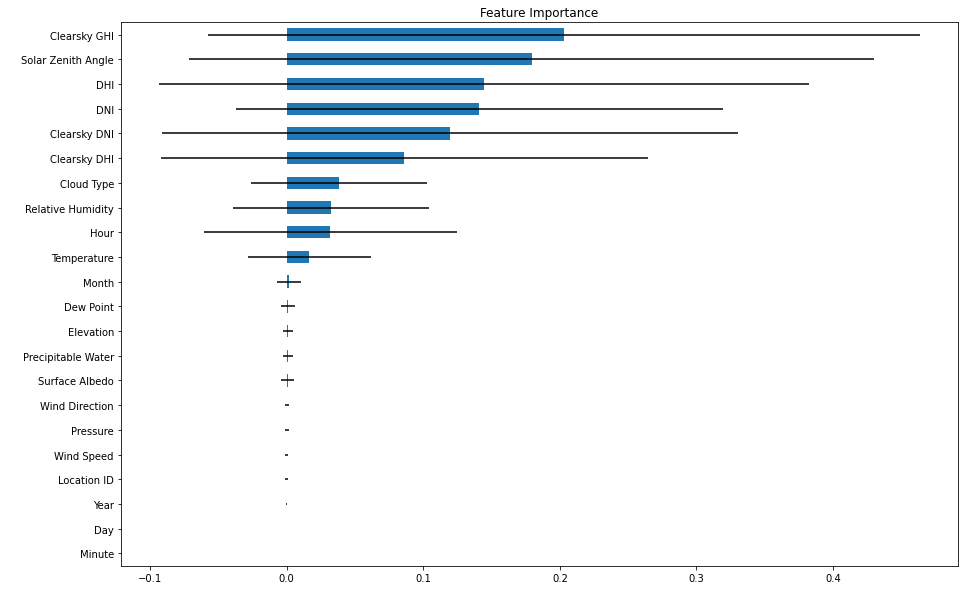

In [31]:
ax = df.plot(kind='barh', xerr='std', x='feature', legend=False,figsize=(15, 10))
ax.set_ylabel(' ')
ax.set_title('Feature Importance')

In [32]:
df.sort_values(by=['importance'],ascending = False,ignore_index = True).head(13)

,feature,importance,std
0,Clearsky GHI,0.202951,0.260562
1,Solar Zenith Angle,0.179400,0.250660
2,DHI,0.144391,0.237708
3,DNI,0.141205,0.178474
4,Clearsky DNI,0.119687,0.210756
5,Clearsky DHI,0.086152,0.178328
6,Cloud Type,0.038526,0.064477
7,Relative Humidity,0.032311,0.071641
8,Hour,0.031903,0.092573
9,Temperature,0.016813,0.044919


# Model Training with all the feature

In [33]:
label_encoder = preprocessing.LabelEncoder()
data['outcome']= label_encoder.fit_transform(data['outcome']) 
y = data['outcome']
y

14        1
20        2
26        0
32        1
38        1
         ..
788366    1
788372    2
788378    2
788384    1
788390    1
Name: outcome, Length: 82125, dtype: int64

In [34]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_X.fit_transform(X)
X

,Year,Month,Day,Hour,Minute,Temperature,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,...,DNI,Relative Humidity,Solar Zenith Angle,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Location ID,Elevation
14,2020,1,1,7,0,-3.5,0,0,0,4,...,0,92.20,93.80,0.11,987,0.400,236.0,5.0,903523,179
20,2020,1,1,10,0,0.0,59,875,358,2,...,414,79.80,70.01,0.11,986,0.300,205.0,6.7,903523,179
26,2020,1,1,13,0,4.3,70,878,418,0,...,878,67.05,66.63,0.11,982,0.500,204.0,7.4,903523,179
32,2020,1,1,16,0,3.6,26,340,50,0,...,203,80.16,86.01,0.11,980,0.700,191.0,7.3,903523,179
38,2020,1,1,19,0,3.2,0,0,0,4,...,0,85.80,117.07,0.11,980,1.100,192.0,8.9,903523,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788366,2016,12,31,7,0,-1.0,0,0,0,4,...,0,88.51,99.30,0.07,1000,0.722,158.8,1.0,241108,49
788372,2016,12,31,10,0,1.0,54,642,202,4,...,642,100.00,76.67,0.07,1000,0.775,188.7,0.9,241108,49
788378,2016,12,31,13,0,2.0,65,729,297,4,...,729,99.53,71.41,0.07,1000,1.055,186.5,1.2,241108,49
788384,2016,12,31,16,0,0.0,17,379,36,1,...,379,73.67,87.15,0.07,1020,0.440,101.8,0.9,241108,49


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=0,stratify=y)

In [36]:
print(f' Shape of X_train : {X_train.shape}')
print(f' Shape of y_train : {y_train.shape}')
print(f' Shape of X_test : {X_train.shape}')
print(f' Shape of y_test : {y_test.shape}')

 Shape of X_train : (57487, 22)
 Shape of y_train : (57487,)
 Shape of X_test : (57487, 22)
 Shape of y_test : (24638,)


## AdaBoost

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

model_ada = AdaBoostClassifier()

# define the grid of values to search

grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['algorithm'] = ['SAMME', 'SAMME.R']
scoring = ['accuracy','f1_macro']

# define the evaluation procedure
grid_search_ada = GridSearchCV(estimator = model_ada , param_grid = grid, n_jobs = -1, refit='accuracy', scoring = scoring)

grid_result = grid_search_ada.fit(X_train, y_train)


In [38]:
grid_result.cv_results_

{'mean_fit_time': array([ 0.80999012,  3.9778419 ,  7.90144334, 39.74079266,  0.79660506,
         3.93775377,  7.91969333, 40.51055803,  0.78470998,  3.90758028,
         7.75817065, 44.83455853,  1.06233749,  5.50161872,  8.45299568,
        40.34228382,  0.81546741,  3.95919905,  8.31740799, 39.38104568,
         0.88145685,  4.35376081,  8.6977931 , 43.8239872 ,  0.99451404,
         4.34408932,  8.63664494, 44.11570349,  0.86794424,  4.34240503,
         8.63195043, 43.13669753,  0.87964993,  4.31066942,  8.61934361,
        43.41475081,  0.87296824,  4.86295304,  8.5949544 , 33.03159604]),
 'std_fit_time': array([5.57020495e-03, 2.85953543e-02, 3.69286210e-02, 2.68279661e-01,
        1.05523164e-02, 3.00660740e-02, 2.28998207e-02, 4.41036652e-01,
        3.29578415e-03, 1.78784114e-02, 1.68599012e-02, 1.80832641e+00,
        5.29809572e-02, 2.89293870e-01, 4.68549885e-01, 5.56856244e-01,
        1.79635635e-02, 7.17985701e-02, 4.48039427e-01, 2.62400883e-01,
        8.47882321e-0

In [39]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.977543 using {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 500}


In [40]:
y_pred = grid_result.predict(X_test) 
y_pred

array([0, 1, 1, ..., 0, 1, 0])

In [41]:
# print classification report 
print('Classification Report')
print(classification_report(y_test, y_pred)) 

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8592
           1       1.00      0.98      0.99     12671
           2       0.86      0.98      0.92      3375

    accuracy                           0.98     24638
   macro avg       0.95      0.98      0.96     24638
weighted avg       0.98      0.98      0.98     24638



In [54]:
# print Confusion Matirx 
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred)) 

Confusion Matrix
[[ 8304     0   288]
 [    0 12416   255]
 [   26    35  3314]]


In [42]:
ada_all_f1_score = f1_score(y_test, y_pred, average = 'macro')
ada_all_accuracy_score = accuracy_score(y_test, y_pred)

print(f'F1 Score of AdaBoost with All Features : {ada_all_f1_score:.3f}')
print(f'Accuracy Score of AdaBoost with All Features: {ada_all_accuracy_score:.3f}')

F1 Score of AdaBoost with All Features : 0.962
Accuracy Score of AdaBoost with All Features: 0.975


In [43]:
model_result = pd.DataFrame(columns=['Model_Name','F1_Score','Accuracy_Score'])
model_result

,Model_Name,F1_Score,Accuracy_Score


In [44]:
list_ada_all = ["AdaBoost All Feature", ada_all_f1_score, ada_all_accuracy_score]
model_result.loc[len(model_result)] = list_ada_all
model_result

,Model_Name,F1_Score,Accuracy_Score
0,AdaBoost All Feature,0.962128,0.975485


# Model Training with selected Features

## AdaBoost

In [45]:
X_train_sf = X_train[['Clearsky GHI', 'Solar Zenith Angle', 'DHI', 'DNI', 'Clearsky DNI', 'Clearsky DHI', 'Cloud Type','Relative Humidity', 'Hour', 'Temperature', 'Month', 'Dew Point', 'Elevation']]
X_test_sf = X_test[['Clearsky GHI', 'Solar Zenith Angle', 'DHI', 'DNI', 'Clearsky DNI', 'Clearsky DHI', 'Cloud Type','Relative Humidity', 'Hour', 'Temperature', 'Month', 'Dew Point', 'Elevation']]


In [46]:
print(f' Shape of X_train : {X_train_sf.shape}')
print(f' Shape of y_train : {y_train.shape}')
print(f' Shape of X_test : {X_train_sf.shape}')
print(f' Shape of y_test : {y_test.shape}')

 Shape of X_train : (57487, 13)
 Shape of y_train : (57487,)
 Shape of X_test : (57487, 13)
 Shape of y_test : (24638,)


In [47]:
model_ada_sf = AdaBoostClassifier()

# define the grid of values to search

grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['algorithm'] = ['SAMME', 'SAMME.R']
scoring = ['accuracy','f1_macro']

# define the evaluation procedure
grid_search_ada_sf = GridSearchCV(estimator = model_ada_sf , param_grid = grid, n_jobs = -1, refit='accuracy', scoring = scoring)

grid_result_sf = grid_search_ada_sf.fit(X_train_sf, y_train)

In [48]:
grid_result_sf.cv_results_

{'mean_fit_time': array([ 0.57750096,  2.7777637 ,  5.49590845, 27.524751  ,  0.54976201,
         2.74532404,  5.49600482, 28.07652173,  0.55535793,  2.74020114,
         5.45512395, 27.4427309 ,  0.54500675,  2.75768738,  5.4854413 ,
        27.53590827,  0.56060667,  2.76676712,  5.52619109, 27.5139328 ,
         0.64546609,  3.2052947 ,  6.79528356, 31.99075103,  0.6524704 ,
         3.19302459,  6.39472084, 31.80657353,  0.64204702,  3.23644195,
         6.41585379, 31.96932054,  0.64159384,  3.18588433,  6.39976325,
        32.45572133,  0.64931459,  3.17524972,  6.3534915 , 24.88622708]),
 'std_fit_time': array([0.01632598, 0.01452807, 0.03251893, 0.09091125, 0.00574697,
        0.01548891, 0.01526963, 0.44794376, 0.0078825 , 0.01616469,
        0.03120314, 0.11954185, 0.00930015, 0.02330135, 0.03203647,
        0.16282307, 0.01212947, 0.02317101, 0.02480568, 0.44478319,
        0.00673768, 0.02123571, 0.30671966, 0.12252574, 0.01035688,
        0.01199163, 0.03239163, 0.1695428

In [49]:
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result_sf.best_score_, grid_result_sf.best_params_))

Best: 0.977543 using {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 500}


In [50]:
y_pred_sf = grid_result_sf.predict(X_test_sf) 

In [51]:
# print classification report 
print('Classification Report')
print(classification_report(y_test, y_pred_sf)) 

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      8592
           1       1.00      0.98      0.99     12671
           2       0.86      0.98      0.92      3375

    accuracy                           0.98     24638
   macro avg       0.95      0.98      0.96     24638
weighted avg       0.98      0.98      0.98     24638



In [55]:
# print Confusion Matirx 
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_sf)) 

Confusion Matrix
[[ 8304     0   288]
 [    0 12416   255]
 [   26    35  3314]]


In [56]:

ada_sf_f1_score = f1_score(y_test, y_pred_sf, average = 'macro')
ada_sf_accuracy_score = accuracy_score(y_test, y_pred_sf)

print(f'Accuracy Score of AdaBoost with Selected Features: {ada_sf_f1_score:.3f}')
print(f'F1 Score of AdaBoost with Selected Features : {ada_sf_accuracy_score:.3f}')


Accuracy Score of AdaBoost with Selected Features: 0.962
F1 Score of AdaBoost with Selected Features : 0.975


In [53]:
list_ada_selected = ["AdaBoost Selected Feature", ada_sf_f1_score, ada_sf_accuracy_score]
model_result.loc[len(model_result)] = list_ada_selected
model_result

,Model_Name,F1_Score,Accuracy_Score
0,AdaBoost All Feature,0.962128,0.975485
1,AdaBoost Selected Feature,0.962128,0.975485
